In [19]:
%%capture
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio -y
!pip install torch==2.6.0 torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth==2025.6.2
!pip install evaluate
!pip install rouge_score
!pip install keybert
!pip install bert-score

In [2]:
from unsloth import FastLanguageModel
from datasets import Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
import nltk
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import os
import re
import numpy as np
import seaborn as sns
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import evaluate
from tqdm import tqdm
import os
from torch.utils.data import DataLoader
from transformers import default_data_collator
from keybert import KeyBERT

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-07-20 08:44:39.897472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753001080.097893     148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753001080.153740     148 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TORCHINDUCTOR_DISABLE_AUTOTUNE"] = "1"


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
df = pd.read_csv("/kaggle/input/medicaltranscriptions/mtsamples.csv")
df = df[df['medical_specialty'].isin([' Surgery',' Orthopedic',' Consult - History and Phy.'])]
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
174,174,Austin & Youngswick bunionectomy with Biopro ...,Surgery,Youngswick Bunionectomy,"PREOPERATIVE DIAGNOSES:,1. Hallux rigidus, le...","surgery, hallux rigidus, metatarsal, youngswic..."
177,177,"This patient has undergone cataract surgery, ...",Surgery,YAG Laser Capsulotomy - 1,"PREOPERATIVE DIAGNOSIS: , Secondary capsular m...","surgery, abraham capsulotomy, yag, yag laser c..."
179,179,Youngswick osteotomy with internal screw fixa...,Surgery,Youngswick Osteotomy,"TITLE OF OPERATION: , Youngswick osteotomy wit...","surgery, hallux limitus deformity, metatarsoph..."
181,181,Wound debridement with removal of Surgisis xe...,Surgery,Wound Debridement,"PREOPERATIVE DIAGNOSES,1. Open wound from rig...","surgery, open wound, prosthetic vascular graft..."
182,182,Visually significant posterior capsule opacit...,Surgery,YAG Laser Capsulotomy,"PREOPERATIVE DIAGNOSIS:, Visually significant...","surgery, capsule opacity, yag, ophthalmic, yag..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1974 entries, 174 to 4602
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1974 non-null   int64 
 1   description        1974 non-null   object
 2   medical_specialty  1974 non-null   object
 3   sample_name        1974 non-null   object
 4   transcription      1959 non-null   object
 5   keywords           1573 non-null   object
dtypes: int64(1), object(5)
memory usage: 108.0+ KB


In [10]:
df.isna().sum()

Unnamed: 0             0
description            0
medical_specialty      0
sample_name            0
transcription         15
keywords             401
dtype: int64

In [11]:
print(f'total duplicated row : {df.duplicated().sum()}')

total duplicated row : 0


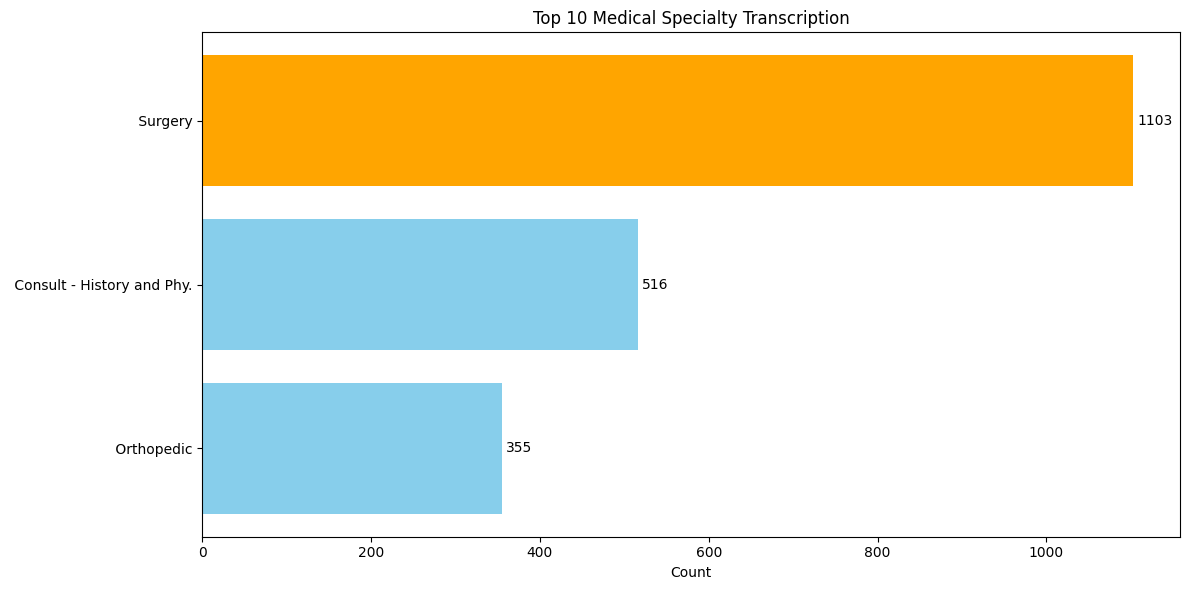

In [13]:

counts = df['medical_specialty'].value_counts()[:10]

colors = ['orange' if i == 0 else 'skyblue' for i in range(len(counts))]

plt.figure(figsize=(12, 6))
bars = plt.barh(counts.index, counts.values, color=colors)

# Add count labels
for bar in bars:
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
             str(int(bar.get_width())), va='center')

plt.title('Top 10 Medical Specialty Transcription')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
df = df.dropna()

def clean_transcription(text):
    text = text.strip()  # Remove leading/trailing whitespaces
    text = re.sub(r'\s+', ' ', text)  # Remove excess spaces and newlines
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    text = re.sub(r"([.,!?;])", r" \1 ", text)  # Space around punctuation
    text = re.sub(r'\s{2,}', ' ', text)  # Remove multiple spaces
    return text.strip()

df['transcription'] = df['transcription'].apply(lambda x : clean_transcription(x))

In [13]:
df['sentence_words_count'] = df['transcription'].str.split().str.len()
df['description_words_count'] = df['description'].str.split().str.len()

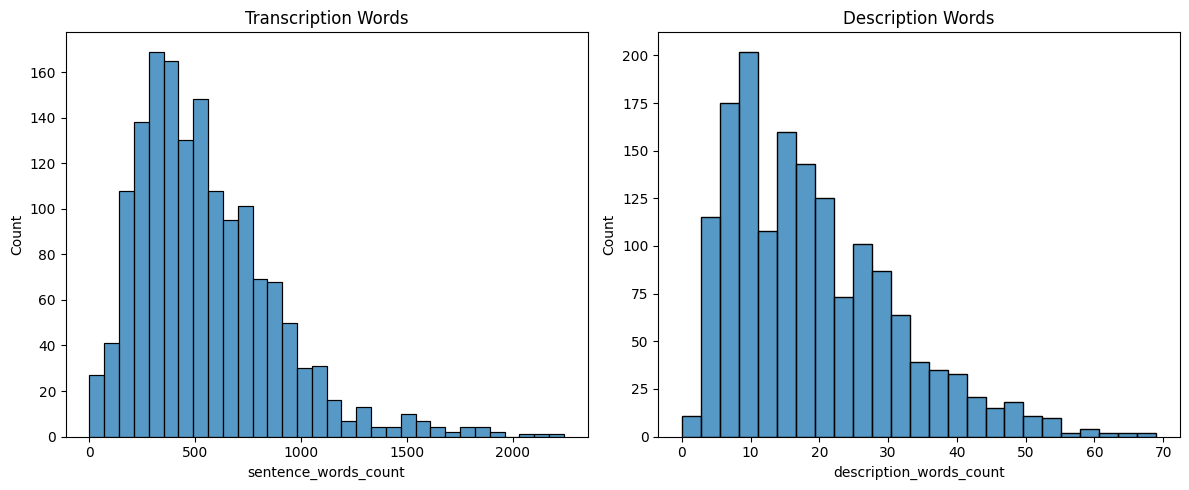

In [14]:
fig, axes = plt.subplots(1,2,figsize = (12,5))
sns.histplot(data = df, x = 'sentence_words_count', ax = axes[0]).set_title('Transcription Words')
sns.histplot(data = df, x = 'description_words_count', ax = axes[1]).set_title('Description Words')
fig.tight_layout()

In [18]:
print('median of words in the transcription :', df['sentence_words_count'].median())
print('max of words in the transcription :', df['sentence_words_count'].max())

median of words in the transcription : 492.5
max of words in the transcription : 2242


In [17]:
print('median of words in the description :', df['description_words_count'].median())
print('max of words in the description :', df['description_words_count'].max())

median of words in the description : 17.0
max of words in the description : 69


In [19]:
def extract_keywords_keybert(text, top_k=22):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), top_n=top_k)
    return ' '.join([kw for kw, _ in keywords])

kw_model = KeyBERT()

df['cleaned_transcript'] = df['transcription'].apply(extract_keywords_keybert)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
df['sentence_words_count_after'] = df['cleaned_transcript'].str.split().str.len()
print('median words after cleaning : ',df['sentence_words_count_after'].median())
print('max words after cleaning : ',df['sentence_words_count_after'].max())

median words after cleaning :  41.0
max words after cleaning :  44


In [18]:
max_seq_length = 2048
dtype = None
load_in_4bit = True 

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/granite-3.2-2b-instruct",
    max_seq_length = max_seq_length,
    dtype = torch.float16,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.6.2: Fast Granite patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [19]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 8, 
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0.2, 
    bias = "none",    
    use_gradient_checkpointing = "unsloth", 
    random_state = 42,
    use_rslora = True, 
)


Unsloth: Making `model.base_model.model.model` require gradients


In [20]:
model.dtype

torch.float16

<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `ChatML` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing).

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [21]:
df_ = df[['cleaned_transcript','description']].dropna()
df_train, df_val = train_test_split(df_, test_size = 0.2, random_state = 42)
df_val, df_test = train_test_split(df_val, test_size = 0.5, random_state = 42)

In [22]:
# Prompt Formatting function using your Alpaca-style instruction
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func_row(row):
    instruction = f"""
            You are given words combination extracted from medical transcription and your task is determine the description \n
        """ 
    input_text = f"Transcription: {row['cleaned_transcript']}\nDescription:"
    prompt = instruction + input_text
    return {
        "prompt": prompt,
        "response": row["description"] + tokenizer.eos_token  # optional for causal LM
    }


# ✅ Apply formatting to all splits
df_train_dicts = df_train.apply(formatting_prompts_func_row, axis=1).tolist()
df_val_dicts   = df_val.apply(formatting_prompts_func_row, axis=1).tolist()
df_test_dicts  = df_test.apply(formatting_prompts_func_row, axis=1).tolist()

In [23]:
df_train = Dataset.from_list(df_train_dicts)
df_val   = Dataset.from_list(df_val_dicts)
df_test  = Dataset.from_list(df_test_dicts)

In [24]:
tokenizer.model_max_length 

131072

In [25]:
from transformers import DataCollatorWithPadding

IGNORE_INDEX = -100
MAX_LENGTH = tokenizer.model_max_length  # usually 4096 or 8192 for Granite

def tokenize_function(example):
    # Tokenize prompt
    prompt = tokenizer(
        example["prompt"],
        truncation=True,
        padding=False,
        max_length=MAX_LENGTH,
    )

    # Tokenize response
    response = tokenizer(
        example["response"],
        truncation=True,
        padding=False,
        add_special_tokens=False,
        max_length=MAX_LENGTH,
    )

    # Add EOS token to response
    response["input_ids"].append(tokenizer.eos_token_id)
    response["attention_mask"].append(1)

    # Combine
    input_ids = prompt["input_ids"] + response["input_ids"]
    attention_mask = prompt["attention_mask"] + response["attention_mask"]
    labels = [IGNORE_INDEX] * len(prompt["input_ids"]) + response["input_ids"]

    # Truncate everything to model max length
    input_ids = input_ids[:MAX_LENGTH]
    attention_mask = attention_mask[:MAX_LENGTH]
    labels = labels[:MAX_LENGTH]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }




collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


df_train = df_train.map(tokenize_function, remove_columns=df_train.column_names)
df_val   = df_val.map(tokenize_function, remove_columns=df_val.column_names)
df_test  = df_test.map(tokenize_function, remove_columns=df_test.column_names)


Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [26]:
from transformers import TrainingArguments
from trl import SFTTrainer
from transformers import DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

training_args = TrainingArguments(
    output_dir                   = "outputs/granite-3.3-summarization-v2",
    per_device_train_batch_size  = 1,  # Reduced for better gradient quality
    gradient_accumulation_steps  = 16, # Increased to maintain effective batch size
    learning_rate                = 1e-5, # Reduced for more stable convergence
    warmup_ratio                 = 0.05, # Reduced warmup for smaller dataset
    lr_scheduler_type            = "cosine",
    max_steps                    = 150,  # Increased for better convergence
    weight_decay                 = 0.01, # Reduced to prevent over-regularization
    fp16                         = not is_bfloat16_supported(),
    bf16                         = is_bfloat16_supported(),
    logging_steps                = 10,   # Less frequent logging
    save_total_limit             = 2,    # Reduced to save disk space
    save_steps                   = 10,  # Save checkpoints periodically
    eval_strategy                = "steps",
    eval_steps                   = 10,  # Evaluate every 200 steps
    load_best_model_at_end       = True,
    metric_for_best_model        = "eval_loss",
    greater_is_better            = False,
    remove_unused_columns        = False,
    seed                         = 3407,
    report_to                    = "none",
    dataloader_num_workers       = 2,    # Improved data loading
    gradient_checkpointing       = True, # Memory optimization
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    padding=True,
    label_pad_token_id=IGNORE_INDEX,
    return_tensors="pt"
)


trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=df_train,
    eval_dataset=df_test,
    train_on_responses_only = False,
    formatting_func=None,
    dataset_text_field=None,
    data_collator=data_collator,
    args=training_args,
)

In [27]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
2.686 GB of memory reserved.


In [28]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,246 | Num Epochs = 4 | Total steps = 150
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 16 x 1) = 32
 "-____-"     Trainable parameters = 14,090,240 of 2,000,000,000 (0.70% trained)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLE

Step,Training Loss,Validation Loss
10,4.233500,2.560643
20,6.126500,2.189739
30,2.903900,1.887745
40,2.744600,1.693782
50,3.465800,1.668347
60,2.528300,1.646704
70,2.882900,1.636334
80,2.573500,1.632847
90,2.469500,1.631538
100,2.250600,1.630796


Unsloth: Will smartly offload gradients to save VRAM!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Unsloth: Not an error, but GraniteForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelis

In [29]:
trainer.save_model("finetuned-IBM-Granite")
tokenizer.save_pretrained("finetuned-IBM-Granite")

('finetuned-IBM-Granite/tokenizer_config.json',
 'finetuned-IBM-Granite/special_tokens_map.json',
 'finetuned-IBM-Granite/chat_template.jinja',
 'finetuned-IBM-Granite/vocab.json',
 'finetuned-IBM-Granite/merges.txt',
 'finetuned-IBM-Granite/added_tokens.json',
 'finetuned-IBM-Granite/tokenizer.json')

## Evaluation

In [32]:
# Load evaluation metrics
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Load your fine-tuned model back (just in case you're in new runtime)

model, tokenizer = FastLanguageModel.from_pretrained(
    "finetuned-IBM-Granite",
    dtype=None,
    load_in_4bit=True
)

==((====))==  Unsloth 2025.6.2: Fast Granite patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [36]:
predictions = []
references = []

for batch in tqdm(df_test):
    # Convert each field to a tensor
    input_ids = torch.tensor(batch["input_ids"]).unsqueeze(0).to(device)          # [1, seq_len]
    attention_mask = torch.tensor(batch["attention_mask"]).unsqueeze(0).to(device)
    labels = torch.tensor(batch["labels"]).unsqueeze(0).to(device)
    
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=128,
            num_beams=4,
            do_sample=False,
        )
    
    # Trim input from generated
    input_length = input_ids.shape[1]
    generated_ids = generated_ids[:, input_length:]
    
    # Decode
    decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    labels[labels == -100] = tokenizer.pad_token_id
    decoded_refs = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    predictions.extend(decoded_preds)
    references.extend(decoded_refs)


100%|██████████| 156/156 [44:30<00:00, 17.12s/it]


In [37]:
# Evaluate BERTScore
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")

BERTScore:


In [38]:
print("BERTScore:")

for score in bertscore_result  : 
    if score != 'hashcode':
        result = np.array(bertscore_result[score]).mean()
        print(f'{score} : {result}')

BERTScore:
precision : 0.7450296359184461
recall : 0.8166497269502053
f1 : 0.7782353988060584
